# Bio.Pairwise2 optimization

This project aims to optimize alignment algorithms from pairwise2 module of BioPython library.
Especially algorithms for local alignments of this library are considerably slow.

### 1. Generate samples

The first step of my project was to measure actual performance of pairwise2 module. To test performance of alignments i wrote a simple script which generates some random samples for alignment tasks.

In [13]:
from generate_samples import generate_sample, PROTEIN_ALPHABET

# Let's generate two sample sequences of proteins. Length of first sequence will be 50.

seq1, seq2 = generate_sample(PROTEIN_ALPHABET, 50)
print "Sequence 1: " + seq1
print "Sequence 2: " + seq2

Sequence 1: GWDISKVPNISFYHEETVNPWKHDLGRSYRMALTGPHHDPMMGNSNFARM
Sequence 2: GWDDSKVPNISFAHEETVNPWKHDLGRLYRMAQPGPHHPMMGNSNWFAR


### 2. Measure Bio.pairwise2 performance

I've already generated some linearly distributed sample sequences of length ~100 - ~3000.
Let's use them to compare speeds of pairwise2 methods.
We will perform alignment of all test sequences and draw nice plots!
Attention: scripts below may take some time (up to ~ 2 minutes) to execute!

Testing generated_1665.fasta...
Testing generated_999.fasta...
Testing generated_1998.fasta...
Testing generated_333.fasta...
Testing generated_666.fasta...
Testing generated_2997.fasta...
Testing generated_1332.fasta...
Testing generated_2664.fasta...
Testing generated_2331.fasta...
Plot saved in "plots"


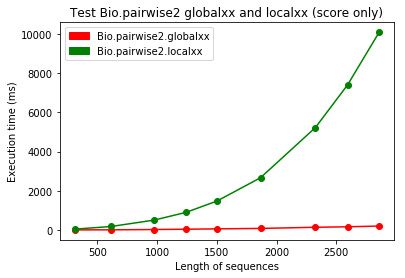

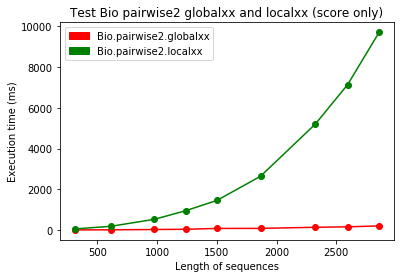

In [15]:
from Bio import pairwise2
from test_optimization import run_compare_test

# Compare globalxx and localxx methods.
# These methods yield global and local alignments for constant gap penalty = 1 and match score = 1

# Search only for score (do not backtrack alignments - much faster)
run_compare_test("Test Bio pairwise2 globalxx and localxx (score only)",
                 [pairwise2.align.globalxx, pairwise2.align.localxx], score_only=True)

# Backtrack alignments
run_compare_test("Test Bio pairwise2 globalxx and localxx",
                 [pairwise2.align.globalxx, pairwise2.align.localxx])

Testing generated_1665.fasta...
Testing generated_999.fasta...
Testing generated_1998.fasta...
Testing generated_333.fasta...
Testing generated_666.fasta...
Testing generated_2997.fasta...
Testing generated_1332.fasta...
Testing generated_2664.fasta...
Testing generated_2331.fasta...
Plot saved in "plots"


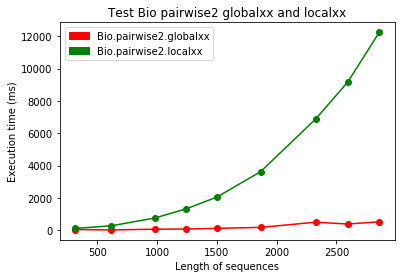

### 3. Analize Bio.pairwise2 performance

As we can see local alignment methods are ridiculously slow! Why is it so? To see what takes so long I inspected Bio.pairwise2 code. The code contains a main method "align" which performs alignment by invoking some other functions. Its code can be divided into several parts:

1. Preparation  (initialization of some structures, checking arguments correctness etc.)
2. Score matrix preparation (actually implemented in C)
3. Finding potential starts of alignments in score matrix (especially important in local alignment)
4. Filtering these starts somehow
5. Recover alignments (transform them to readable form)

I created my class deriving base class of alignment from pairwise2. I overrode this "align" method by copying original code and adding measuring of time of its parts. Then i wrote a script which executes this code several times for a few sample sequence pairs and plots execution times of each part.

Again, code below may take some time to execute (~ 3 minutes).

--------------------
Analysis of Bio pairwise2 localxx execution time (score only)
--------------------
Total time: 400.96 ms
--------------------
Preparation: 0.02 ms
Making score and trace matrices: 16.67 ms
Finding possible starts: 384.27 ms
Filtering starts: 0.00 ms
Recovering alignment: 0.00 ms
Plot saved in "plots"


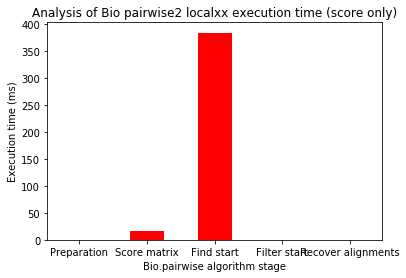


--------------------
Analysis of Bio pairwise2 globalxx execution time (score only)
--------------------
Total time: 25.11 ms
--------------------
Preparation: 0.02 ms
Making score and trace matrices: 25.09 ms
Finding possible starts: 0.01 ms
Filtering starts: 0.00 ms
Recovering alignment: 0.00 ms
Plot saved in "plots"


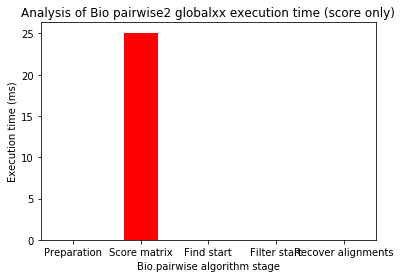


--------------------
Analysis of Bio pairwise2 localxx execution time
--------------------
Total time: 724.67 ms
--------------------
Preparation: 0.02 ms
Making score and trace matrices: 36.26 ms
Finding possible starts: 387.91 ms
Filtering starts: 279.65 ms
Recovering alignment: 20.82 ms
Plot saved in "plots"


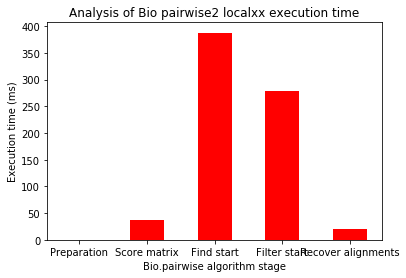


--------------------
Analysis of Bio pairwise2 globalxx execution time
--------------------
Total time: 65.01 ms
--------------------
Preparation: 0.05 ms
Making score and trace matrices: 40.25 ms
Finding possible starts: 0.01 ms
Filtering starts: 0.01 ms
Recovering alignment: 24.70 ms
Plot saved in "plots"


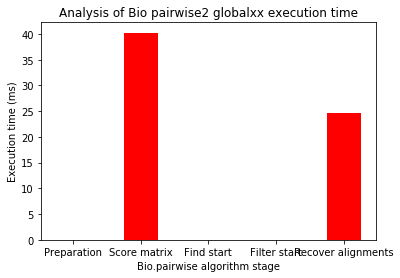

In [19]:
from analyze_bio_speed import perform_test
from generate_samples import generate_sample, PROTEIN_ALPHABET 

# Let's generate 3 samples of lengths ~ 1000
samples_count, seq_len = 3, 1000
seq_pairs = [generate_sample(PROTEIN_ALPHABET, seq_len)] * samples_count

# Analyze execution time of localxx with score_only=True
perform_test(seq_len, seq_pairs, "localxx", "Analysis of Bio pairwise2 localxx execution time (score only)", score_only=True)

# Analyze execution time of globalxx with score_only=True
perform_test(seq_len, seq_pairs, "globalxx", "Analysis of Bio pairwise2 globalxx execution time (score only)", score_only=True)

# Analyze execution time of localxx with backtracing alignments
perform_test(seq_len, seq_pairs, "localxx", "Analysis of Bio pairwise2 localxx execution time")

# Analyze execution time of globalxx with backtracing alignments
perform_test(seq_len, seq_pairs, "globalxx", "Analysis of Bio pairwise2 globalxx execution time")


### 4. Find the bottleneck

As we can see, time spent on global algorithms seems reasonable. However, in local alignment, vast amount of time is taken by finding and filtering start, which should not be the case.
I looked into the original code for finding starts. It looks like this:

:::python 

""" Fragment of code in "align" method: """
""" finding starts: """
starts = _find_start(score_matrix, align_globally) 
best_score = max([x[0] for x in starts]) 
  
if score_only: 
     return best_score 
  
tolerance = 0  # This seems to be placeholder for a future feature of giving some tolerance on best score

""" filtering starts: """
starts = [(score, pos) for score, pos in starts 
          if rint(abs(score - best_score)) <= rint(tolerance)] 


""" _find_start method used in "align" method: """
def _find_start(score_matrix, align_globally): 
     if align_globally: 
         starts = [(score_matrix[-1][-1], (nrows - 1, ncols - 1))] 
     else: 
         starts = [] 
         for row in range(nrows): 
             for col in range(ncols): 
                 score = score_matrix[row][col] 
                 starts.append((score, (row, col))) 
     return starts 

Let's cosider local alignments olny (performance of global alignments is OK). I see the following problems with the code above:

1. Method find_start is invoked always, even if score_only=True and we don't want to bactrace alignments
2. In find_start method, for local alignment, we create a list of starts. Then we append nrows * ncols elements to this list. Given two sequences of lengths ~ 1000, this means 1000000 append operations. As it turned out, this is the bottleneck - appending single elements to list in Python is not so fast.
3. We filter starts by comparing scores in starts with best_score. Tolerance is 0 anyway, so instead of computing rint(abs(score - best_score)) <== rint(tolerance) we can just take all starts with score == best_score.

### 5. Fix the bottleneck

I fixed code above, so it does not create matrix of size nrows * ncols, but takes only starts with score == best_score at first.
It also doesn't find starts if we look only for score.

:::python 

""" Fragment of code in "align" method: """
nrows, ncols = len(score_matrix), len(score_matrix[0]) 
 
if align_globally:
    starts = [(score_matrix[nrows-1][ncols-1], (nrows-1,ncols-1))]
    if score_only: 
        return starts[0][0]
else:
    best_score = max(score_matrix[row][col] for row, col in itertools.product(xrange(nrows), xrange(ncols)))
    if score_only: 
        return best_score 

    starts = _find_start(score_matrix, best_score) 

    
""" _find_start method used in "align" method: """ 
def _find_start(score_matrix, best_score): 
    nrows, ncols = len(score_matrix), len(score_matrix[0]) 

    return [(best_score, (row, col)) for row, col in itertools.product(xrange(nrows), xrange(ncols))
            if score_matrix[row][col] == best_score]

In [ ]:
# Let's see how new code affects performance
# Again - this methods can take some time, ~ 2 minutes each

from Bio import pairwise2
from lib import optimized_pairwise2
from test_optimization import run_compare_test

# Compare original and optimized localxx methods.

description = "Compare localxx methods (score only)"
print(description)
run_compare_test(description, [pairwise2.align.localxx, optimized_pairwise2.align.localxx], score_only=True)

description = "Compare localxx methods (including alignments)"
print(description)
run_compare_test(description, [pairwise2.align.localxx, optimized_pairwise2.align.localxx])

### 6. Test equivalence of results

My task is too optimize existing library, so it is very important that its behavior doesn't change so it can easily replace the original.
I assured correctness of results by creating a unit test module. It tests for several methods that results from optimized library are exactly same as results from the original.
I don't perform unit test on generated samples. Instead I manually create some test samples for unit tests. They include special cases as empty sequences, two same sequences etc.

Executing all unittests takes really long (because we test original local alignment methods which are terribly slow), however done once it assures that i didn't mess up anything.

In [ ]:
from testdata.test_sequences import get_test_sequences_pairs, all_equal
from run_unittests import AlignmentEquivalenceTestCase

# get all sequence pairs for unit testing
sequence_pairs = [(seq1, seq2) for _, seq1, seq2 in get_test_sequences_pairs(['unit'])]

# creates test suite which tests all methods on all sequence pairs
test_suite = AlignmentsEquivalenceTestCase.get_test_suite(sequence_pairs)

# this takes very very long
unittest.TextTestRunner().run(test_suite)